In [1]:
!pip install imbalanced-learn
!pip install pandas
!pip install pandas scikit-learn


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

In [ ]:
df = pd.read_csv('../data/AIDS_Classification_50000.csv')

df_majority = df[df.infected == 0]
df_minority = df[df.infected == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=123)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

print(df_balanced['infected'].value_counts())

df_balanced.to_csv('../data/AIDS_Classification_50000_balanced.csv', index=False)


infected
0    34494
1    34494
Name: count, dtype: int64


In [8]:
X = df_balanced.drop('infected', axis=1)
y = df_balanced['infected']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


random forest

Params: n_estimators=100, max_features=sqrt - Validation Accuracy: 0.8322945354399188
Params: n_estimators=100, max_features=log2 - Validation Accuracy: 0.8322945354399188
Params: n_estimators=300, max_features=sqrt - Validation Accuracy: 0.8349036092187273
Params: n_estimators=300, max_features=log2 - Validation Accuracy: 0.8349036092187273
Params: n_estimators=500, max_features=sqrt - Validation Accuracy: 0.8340339179591245
Params: n_estimators=500, max_features=log2 - Validation Accuracy: 0.8340339179591245
Best Parameters: n_estimators=300, max_features=sqrt with a Validation Accuracy of 0.8349036092187273
Test Accuracy: 0.8653428033048268
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      6807
           1       0.85      0.89      0.87      6991

    accuracy                           0.87     13798
   macro avg       0.87      0.86      0.87     13798
weighted avg       0.87      0.87      0.87     13798



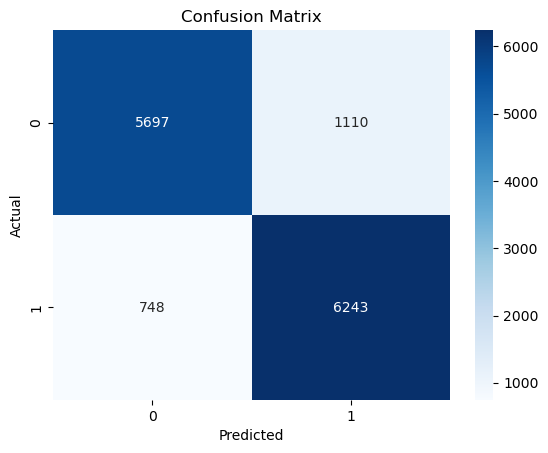

Negative Predictive Value (NPV): 0.8839410395655547


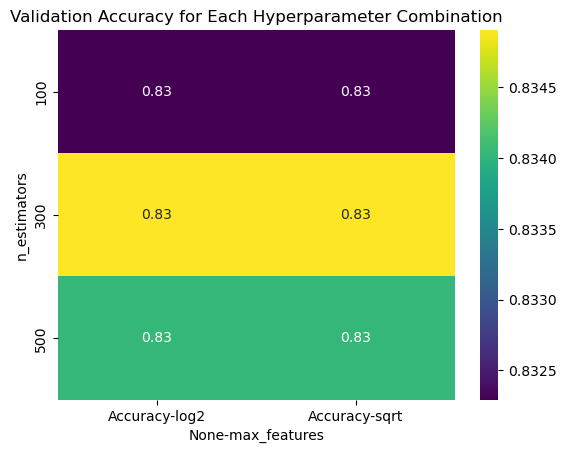

In [15]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['sqrt', 'log2']
}

best_score = 0
best_params = {}
all_scores = {}

for n_estimators in param_grid['n_estimators']:
    for max_features in param_grid['max_features']:
        rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=42)
        rf.fit(X_train, y_train)
        score = rf.score(X_val, y_val)
        all_scores[(n_estimators, max_features)] = score
        if score > best_score:
            best_score = score
            best_params = {'n_estimators': n_estimators, 'max_features': max_features}

for params, score in all_scores.items():
    print(f"Params: n_estimators={params[0]}, max_features={params[1]} - Validation Accuracy: {score}")

print(f"Best Parameters: n_estimators={best_params['n_estimators']}, max_features={best_params['max_features']} with a Validation Accuracy of {best_score}")

best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_val, y_train_val)

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]
NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
print(f"Negative Predictive Value (NPV): {NPV}")

scores_matrix = pd.DataFrame(all_scores.values(), index=pd.MultiIndex.from_tuples(all_scores.keys(), names=["n_estimators", "max_features"]), columns=["Accuracy"])
sns.heatmap(scores_matrix.unstack(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Validation Accuracy for Each Hyperparameter Combination')
plt.show()


log reg

Validation Accuracies for Each Hyperparameter Combination:
Params: C=0.1, solver='liblinear' - Validation Accuracy: 0.6552398898391071
Params: C=1, solver='liblinear' - Validation Accuracy: 0.6552398898391071
Params: C=10, solver='liblinear' - Validation Accuracy: 0.6552398898391071
Test Accuracy: 0.6495144223800551
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      6807
           1       0.64      0.70      0.67      6991

    accuracy                           0.65     13798
   macro avg       0.65      0.65      0.65     13798
weighted avg       0.65      0.65      0.65     13798



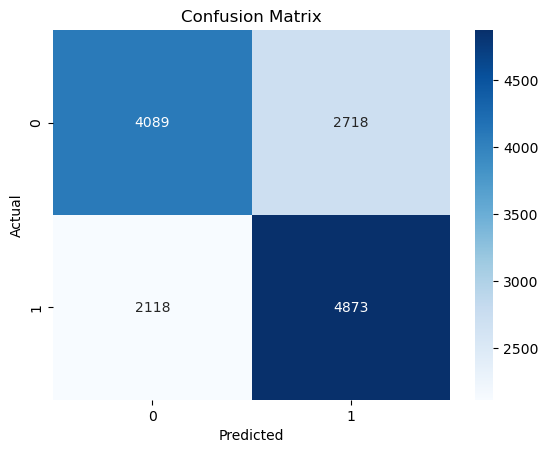

Negative Predictive Value (NPV): 0.6587723537941035


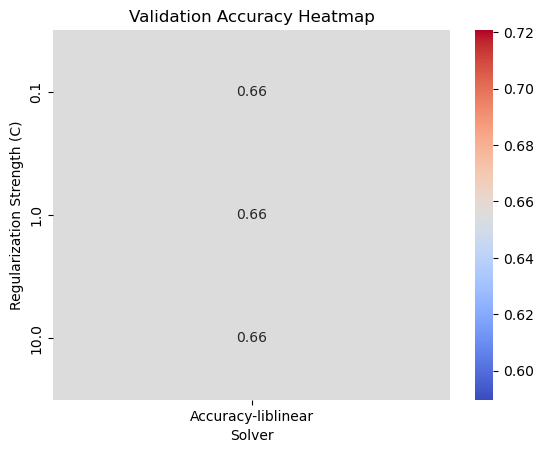

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

best_score = 0
best_params = {}
all_scores = {}

for C in param_grid['C']:
    for solver in param_grid['solver']:
        log_reg = LogisticRegression(C=C, solver=solver, random_state=42)
        log_reg.fit(X_train_scaled, y_train)
        score = log_reg.score(X_val_scaled, y_val)
        all_scores[(C, solver)] = score
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'solver': solver}

print("Validation Accuracies for Each Hyperparameter Combination:")
for params, score in all_scores.items():
    print(f"Params: C={params[0]}, solver='{params[1]}' - Validation Accuracy: {score}")

best_log_reg = LogisticRegression(**best_params, random_state=42)
best_log_reg.fit(np.vstack((X_train_scaled, X_val_scaled)), np.concatenate((y_train, y_val)))

y_pred = best_log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]
NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
print(f"Negative Predictive Value (NPV): {NPV}")

acc_matrix = pd.DataFrame.from_dict(all_scores, orient='index', columns=['Accuracy'])
acc_matrix.index = pd.MultiIndex.from_tuples(acc_matrix.index, names=['C', 'Solver'])
sns.heatmap(acc_matrix.unstack(level='Solver'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Validation Accuracy Heatmap')
plt.ylabel('Regularization Strength (C)')
plt.xlabel('Solver')
plt.show()


Validation Accuracies for Each Hyperparameter Combination:
Params: C=0.1, kernel='linear' - Validation Accuracy: 0.630816060298594
Params: C=0.1, kernel='rbf' - Validation Accuracy: 0.6577764893462821
Params: C=1, kernel='linear' - Validation Accuracy: 0.630816060298594
Params: C=1, kernel='rbf' - Validation Accuracy: 0.673793303377301
Params: C=10, kernel='linear' - Validation Accuracy: 0.630816060298594
Params: C=10, kernel='rbf' - Validation Accuracy: 0.7061168285258733
Test Accuracy: 0.7195245687780838
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      6807
           1       0.70      0.78      0.74      6991

    accuracy                           0.72     13798
   macro avg       0.72      0.72      0.72     13798
weighted avg       0.72      0.72      0.72     13798



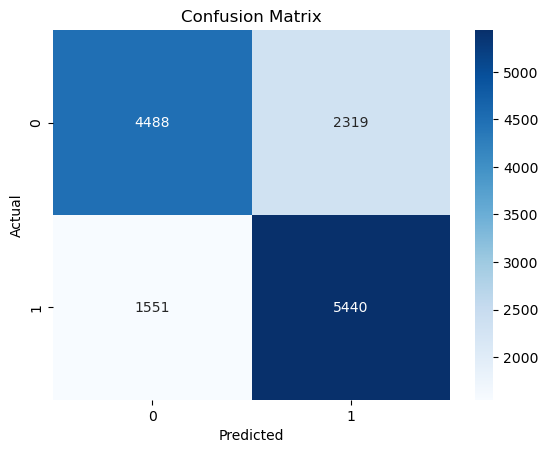

Negative Predictive Value (NPV): 0.7431693989071039


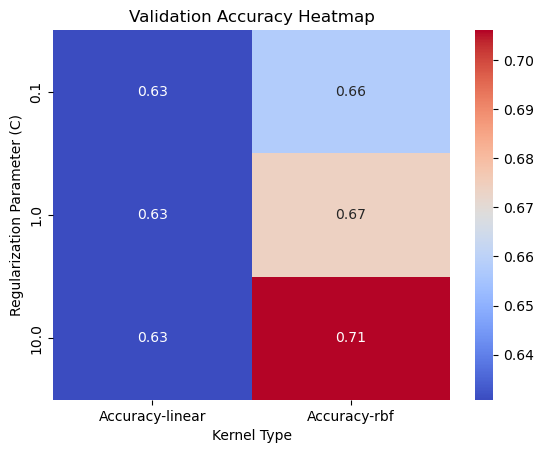

In [17]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

best_score = 0
best_params = {}
all_scores = {}

for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        svc = SVC(C=C, kernel=kernel, random_state=42)
        svc.fit(X_train_scaled, y_train)
        score = svc.score(X_val_scaled, y_val)
        all_scores[(C, kernel)] = score
        if score > best_score:
            best_score = score
            best_params = {'C': C, 'kernel': kernel}


print("Validation Accuracies for Each Hyperparameter Combination:")
for params, score in all_scores.items():
    print(f"Params: C={params[0]}, kernel='{params[1]}' - Validation Accuracy: {score}")

best_svc = SVC(**best_params, random_state=42)
best_svc.fit(np.vstack((X_train_scaled, X_val_scaled)), np.concatenate((y_train, y_val)))

y_pred = best_svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]
NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
print(f"Negative Predictive Value (NPV): {NPV}")

acc_matrix = pd.DataFrame.from_dict(all_scores, orient='index', columns=['Accuracy'])
acc_matrix.index = pd.MultiIndex.from_tuples(acc_matrix.index, names=['C', 'Kernel'])
sns.heatmap(acc_matrix.unstack(level='Kernel'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Validation Accuracy Heatmap')
plt.ylabel('Regularization Parameter (C)')
plt.xlabel('Kernel Type')
plt.show()


C:\Users\Inginer\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Inginer\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Inginer\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Inginer\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Validation Accuracies for Each Hyperparameter Combination:
Params: n_estimators=50, learning_rate=0.1 - Validation Accuracy: 0.6550224670242064
Params: n_estimators=50, learning_rate=1.0 - Validation Accuracy: 0.6592259747789535
Params: n_estimators=100, learning_rate=0.1 - Validation Accuracy: 0.65610958109871
Params: n_estimators=100, learning_rate=1.0 - Validation Accuracy: 0.659298449050587


C:\Users\Inginer\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test Accuracy: 0.6593709233222206
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      6807
           1       0.65      0.70      0.68      6991

    accuracy                           0.66     13798
   macro avg       0.66      0.66      0.66     13798
weighted avg       0.66      0.66      0.66     13798



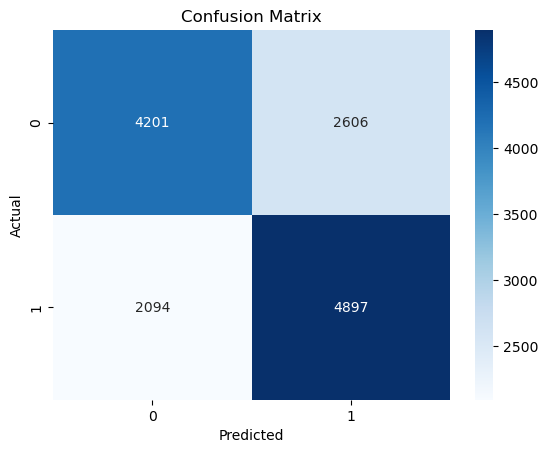

Negative Predictive Value (NPV): 0.6673550436854646


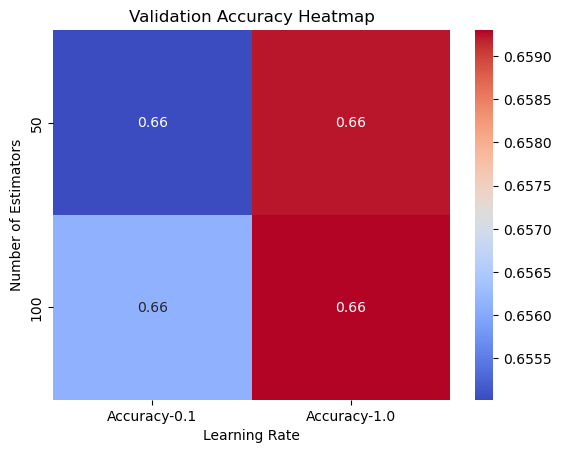

In [18]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1.0]
}

best_score = 0
best_params = {}
all_scores = {}

base_estimator = DecisionTreeClassifier(max_depth=1)

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        ada = AdaBoostClassifier(base_estimator=base_estimator, 
                                 n_estimators=n_estimators, 
                                 learning_rate=learning_rate, 
                                 random_state=42)
        ada.fit(X_train, y_train)
        score = ada.score(X_val, y_val)
        all_scores[(n_estimators, learning_rate)] = score
        if score > best_score:
            best_score = score
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

print("Validation Accuracies for Each Hyperparameter Combination:")
for params, score in all_scores.items():
    print(f"Params: n_estimators={params[0]}, learning_rate={params[1]} - Validation Accuracy: {score}")

best_ada = AdaBoostClassifier(base_estimator=base_estimator, 
                              **best_params, 
                              random_state=42)
best_ada.fit(X_train_val, y_train_val)

y_pred = best_ada.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]
NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
print(f"Negative Predictive Value (NPV): {NPV}")

acc_matrix = pd.DataFrame.from_dict(all_scores, orient='index', columns=['Accuracy'])
acc_matrix.index = pd.MultiIndex.from_tuples(acc_matrix.index, names=['n_estimators', 'learning_rate'])
sns.heatmap(acc_matrix.unstack(level='learning_rate'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Validation Accuracy Heatmap')
plt.ylabel('Number of Estimators')
plt.xlabel('Learning Rate')
plt.show()


In [13]:
!pip install catboost


Validation Accuracies for Each Hyperparameter Combination:
Params: n_estimators=50, learning_rate=0.1 - Validation Accuracy: 0.6651688650529062
Params: n_estimators=50, learning_rate=1.0 - Validation Accuracy: 0.6576315408030149
Params: n_estimators=100, learning_rate=0.1 - Validation Accuracy: 0.6692274242643862
Params: n_estimators=100, learning_rate=1.0 - Validation Accuracy: 0.6782142339469488
Test Accuracy: 0.6760400057979418
              precision    recall  f1-score   support

           0       0.68      0.65      0.66      6807
           1       0.67      0.70      0.69      6991

    accuracy                           0.68     13798
   macro avg       0.68      0.68      0.68     13798
weighted avg       0.68      0.68      0.68     13798



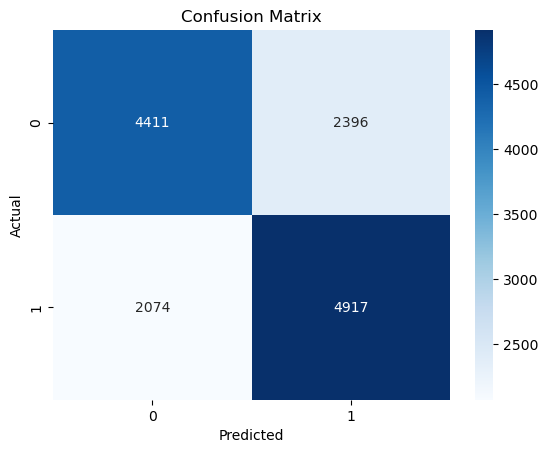

Negative Predictive Value (NPV): 0.6801850424055512


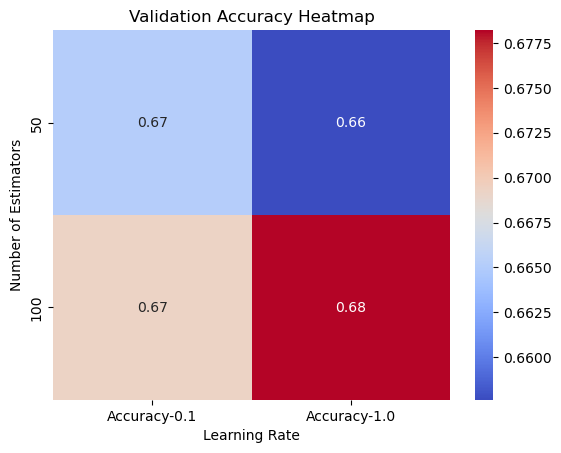

In [19]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1.0]
}

best_score = 0
best_params = {}
all_scores = {}

for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        cat = CatBoostClassifier(n_estimators=n_estimators,
                                 learning_rate=learning_rate,
                                 random_state=42,
                                 verbose=False)
        cat.fit(X_train, y_train)
        score = cat.score(X_val, y_val)
        all_scores[(n_estimators, learning_rate)] = score
        if score > best_score:
            best_score = score
            best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

print("Validation Accuracies for Each Hyperparameter Combination:")
for params, score in all_scores.items():
    print(f"Params: n_estimators={params[0]}, learning_rate={params[1]} - Validation Accuracy: {score}")

best_cat = CatBoostClassifier(**best_params, random_state=42, verbose=False)
best_cat.fit(X_train_val, y_train_val)

y_pred = best_cat.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]
NPV = TN / (TN + FN) if (TN + FN) != 0 else 0
print(f"Negative Predictive Value (NPV): {NPV}")

acc_matrix = pd.DataFrame.from_dict(all_scores, orient='index', columns=['Accuracy'])
acc_matrix.index = pd.MultiIndex.from_tuples(acc_matrix.index, names=['n_estimators', 'learning_rate'])
sns.heatmap(acc_matrix.unstack(level='learning_rate'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Validation Accuracy Heatmap')
plt.ylabel('Number of Estimators')
plt.xlabel('Learning Rate')
plt.show()
